# TLDI: Tea Leave Disease Identifier 
**Model Spesifications**
```
version: v0.1.0
total_param: Null
model_type: Custom Convolutional Neural Network (CNN)
model_layers: [
    Null
]
train_data_length: Null
test_data_length: Null
```

**WARNING:** 
1. **THIS MODEL IS STILL UNDER DEVELOPMENT!**

Data source: [Kaggle](https://www.kaggle.com/datasets/shashwatwork/identifying-disease-in-tea-leafs)

Kaggle public API (require 'kaggle.json' file, visit [Kaggle API](https://www.kaggle.com/docs/api)): 
```
# command prompt
kaggle datasets download -d shashwatwork/identifying-disease-in-tea-leafs
```

## Importing Dependencies

In [1]:
# if module split-folders is not installed
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
try:
    import numpy as np
    import pandas as pd
    import os
    import shutil
    from zipfile import ZipFile
    import cv2
    import splitfolders
    import random

    import tensorflow as tf
    import keras
    from keras import Sequential
    from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
    from keras.layers import Input
    from keras.applications.resnet_v2 import ResNet152V2
    from keras.preprocessing.image import ImageDataGenerator

    import matplotlib
    import matplotlib.pyplot as plt
    from IPython.display import display
    from sklearn.metrics import classification_report

    matplotlib.style.use('ggplot')
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
except Exception:
    raise Exception(f"Error on importing dependencies!")
finally:
    print(f"Success on importing dependencies!")

# for google colab users
from google.colab import files

Success on importing dependencies!


In [3]:
def kaggle(origin_path: str, dataset_urls=None, copy=True):
    """
    Params
    ------
    origin_path <str>: kaggle.json file location
    dataset_urls <list><str>: dataset url in "[users]/[datasetname]" format
    copy <bool>: copy if True or move if False, kaggle.json file
    """
    root_dir = "/root/.kaggle"
    file_name = "kaggle.json"
    file_loc = os.path.join(root_dir, file_name)

    if not os.path.isdir(root_dir):
        os.mkdir(root_dir)

    if copy:
        shutil.copy(origin_path, root_dir)
        message = f"'kaggle.json' file has been copied to {file_loc}!"
    elif not copy:
        shutil.move(origin_path, root_dir)
        message = f"'kaggle.json' file has been moved to {file_loc}!"

    os.chmod(file_loc, 600)
    print(message)

    if dataset_urls is not None:
        from kaggle.api.kaggle_api_extended import KaggleApi

        api = KaggleApi()
        api.authenticate()

        for dataset in dataset_urls:
            api.dataset_download_cli(dataset)

        print(f"Dataset has been successfully downloaded!")

def unzip(path: str, del_src: bool):
    zip_ref = ZipFile(path, 'r')
    zip_ref.extractall(os.getcwd())
    zip_ref.close()

    if del_src:
        os.remove(path)

    print(f"\"{path}\" has been extracted!")

def ws_setup(ws_name: str, data_origins: list):
    loc = os.getcwd()
    ws_path = os.path.join(loc, ws_name)

    if not os.path.isdir(ws_path):
        os.mkdir(ws_path)
    else:
        raise Exception(f"\"{ws_name}\" directory already exists!")

    for data in data_origins:
        shutil.move(data, ws_path)

    os.chdir(ws_path)

    print(f"current workspace directory \"{os.getcwd()}\"")

def display_dfs(dataframes: list):
    for dataframe in dataframes:
        display(dataframe)

## Project Preparation

In [4]:
loc = os.getcwd()

# for colab user to upload the kaggle identifier file
files.upload()

kaggle(
    origin_path=os.path.join(loc, "kaggle.json"),
    dataset_urls=["shashwatwork/identifying-disease-in-tea-leafs"],
    copy=False
)

Saving kaggle.json to kaggle.json
'kaggle.json' file has been moved to /root/.kaggle/kaggle.json!


100%|██████████| 740M/740M [00:31<00:00, 24.5MB/s]


Dataset has been successfully downloaded!


In [5]:
unzip("./identifying-disease-in-tea-leafs.zip", del_src=True)

"./identifying-disease-in-tea-leafs.zip" has been extracted!


In [6]:
ws_setup(ws_name="tldi_workspace", data_origins=["./tea sickness dataset"])

current workspace directory "/content/tldi_workspace"


## Data Analysis

In [7]:
parent_dir = os.path.join(".", "tea sickness dataset")
y = os.listdir(parent_dir)

data = list()
unique_disease_identifier = {}

for label_to_dict in y:
    unique_disease_identifier[label_to_dict] = y.index(label_to_dict)

for subdir in y:
    subdir_loc = os.path.join(parent_dir, subdir)
    subdir_n_data = len(os.listdir(subdir_loc))

    for append_data in range(subdir_n_data):
        data.append(unique_disease_identifier[subdir])

print(data)
print(unique_disease_identifier)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

,disease
0,0
1,0
2,0
3,0
4,0
...,...
880,7
881,7
882,7
883,7


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5f91686b10>]],
      dtype=object)

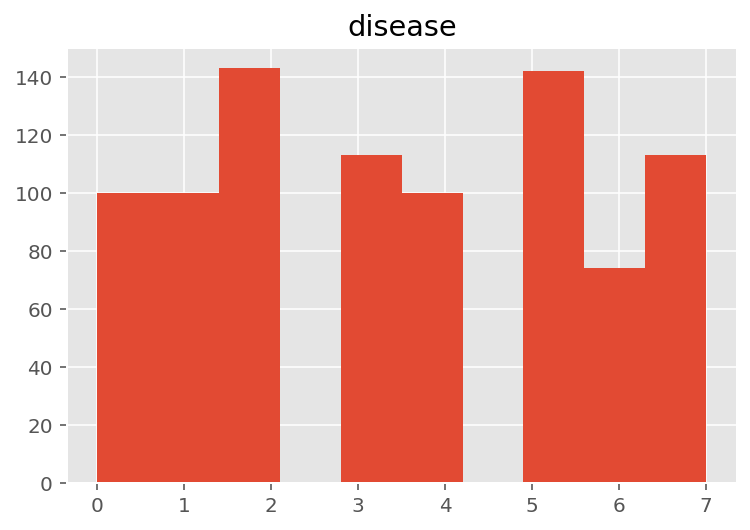

In [8]:
data_distribution = pd.DataFrame(
    data,
    columns=["disease"]
)

display_dfs([data_distribution])
data_distribution.hist()

## Preprocessing

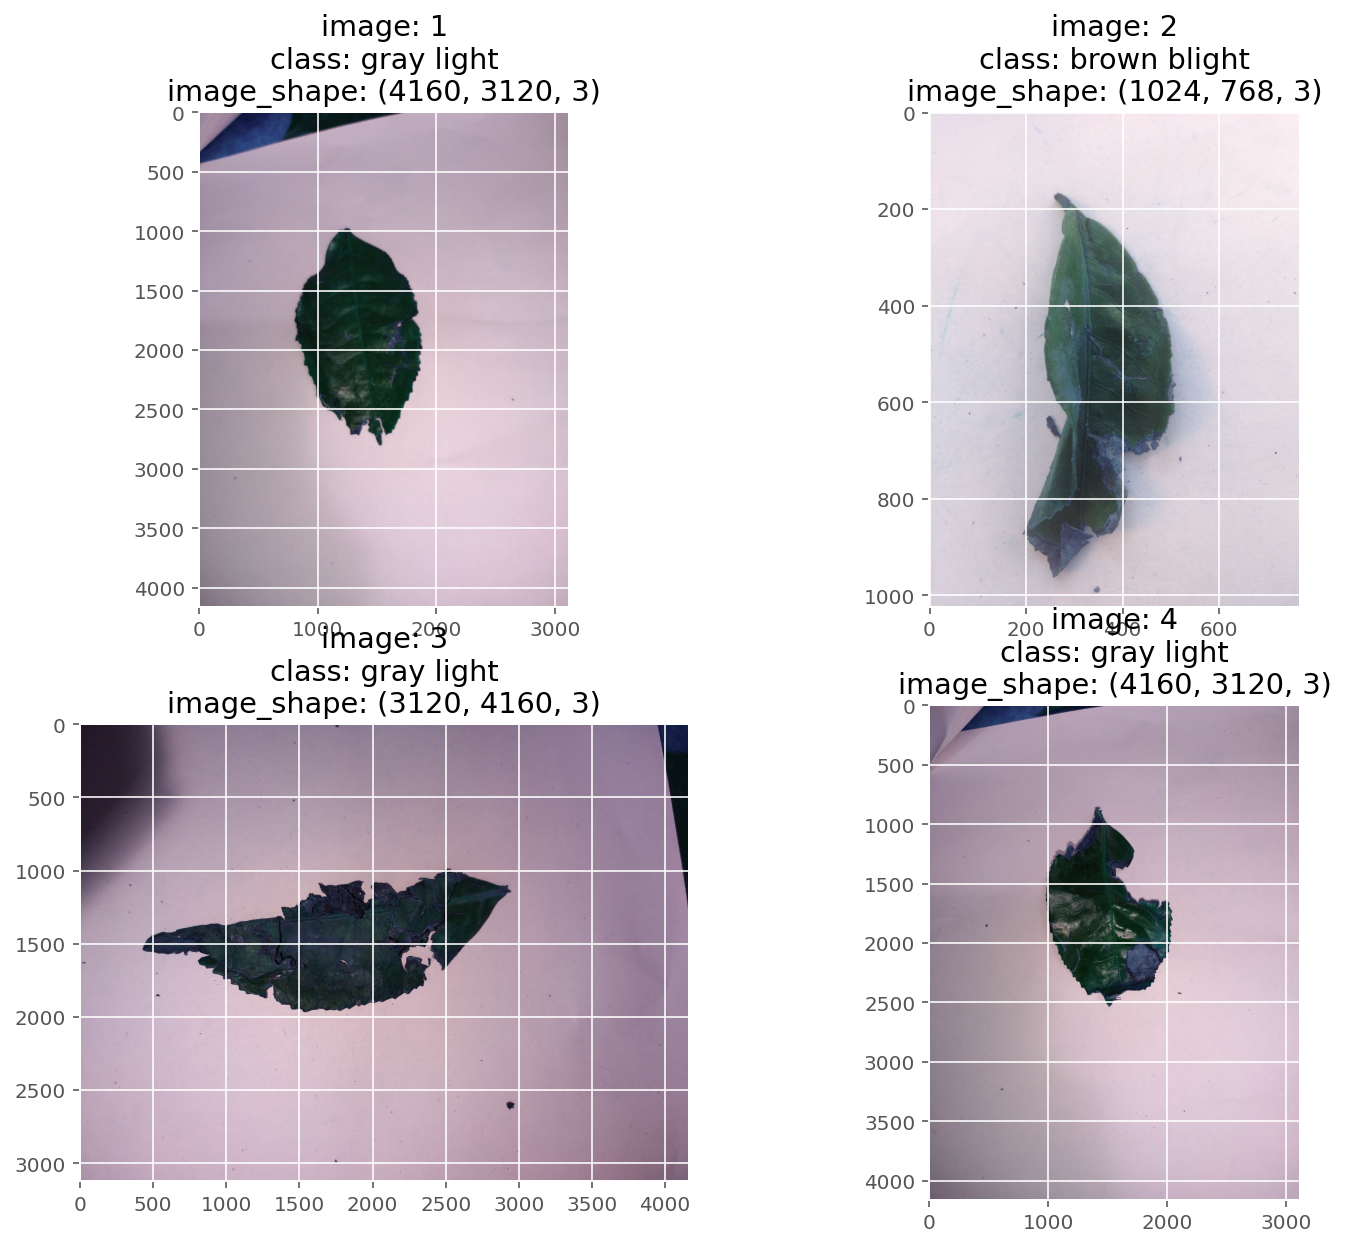

In [67]:
rows, columns = (2, 2)
fig = plt.figure(figsize=(12, 10))

for index in range(1, columns*rows+1):
    rand_subdir = str(str(str(random.choices(os.listdir(parent_dir))).replace("[", "")).replace("]", "")).replace("'", "")
    subdir_loc = os.path.join(parent_dir, rand_subdir)

    subdir_imgs = os.listdir(subdir_loc)
    img_loc = os.path.join(subdir_loc, subdir_imgs[random.randint(0, len(subdir_imgs)-1)])
    img = cv2.imread(img_loc)
    
    fig.add_subplot(rows, columns, index)
    plt.title(f"image: {index}\nclass: {rand_subdir}\nimage_shape: {img.shape}")
    plt.imshow(img)

plt.show()

We can see from the results above that the images is not in the same dimension

In [72]:
splitfolders.ratio(
    parent_dir,
    output="tea_sickness_dataset",
    seed=2345, ratio=(.8, .1, .1),
    move=False
)

Copying files: 885 files [00:05, 148.22 files/s]


In [73]:
parent_dir = os.path.join(os.getcwd(), "tea_sickness_dataset")

In [75]:
train_dir = os.path.join(parent_dir, "train")
test_dir = os.path.join(parent_dir, "test")
val_dir = os.path.join(parent_dir, "val")

train_files = list()
test_files = list()
val_files = list()

train_length = list()
test_length = list()
val_length = list()

for train_parent_subdir in os.listdir(train_dir):
    files_loc = os.path.join(train_dir, train_parent_subdir)
    files = os.listdir(files_loc)
    train_files.append(files)

for get_train_length in train_files:
    length = len(get_train_length)
    train_length.append(length)

for test_parent_subdir in os.listdir(test_dir):
    files_loc = os.path.join(test_dir, test_parent_subdir)
    files = os.listdir(files_loc)
    test_files.append(files)

for get_test_length in test_files:
    length = len(get_test_length)
    test_length.append(length)

for val_parent_subdir in os.listdir(val_dir):
    files_loc = os.path.join(val_dir, val_parent_subdir)
    files = os.listdir(files_loc)
    val_files.append(files)

for get_val_length in val_files:
    length = len(get_val_length)
    val_length.append(length)

print(f"train data length: {sum(train_length)}\ntest data length: {sum(test_length)}\nvalidation data length: {sum(val_length)}\ntotal dataset length: {sum(train_length)+sum(test_length)+sum(val_length)}")

train data length: 618
test data length: 93
validation data length: 174
total dataset length: 885


In [76]:
image_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode="nearest",
)

In [78]:
train_dir = os.path.join(parent_dir, "train")
val_dir = os.path.join(parent_dir, "val")
size = (256, 256)

train_generator = image_datagen.flow_from_directory(
    train_dir,
    target_size=(size),
    batch_size=15,
    class_mode='categorical',
    subset='training'
)

validation_generator = image_datagen.flow_from_directory(
    val_dir,
    target_size=(size),
    batch_size=30,
    class_mode='categorical',
    subset='validation'
)

Found 618 images belonging to 8 classes.
Found 0 images belonging to 8 classes.
